# Dynamic Pricing for Hotel Rooms — Notebook

This notebook walks through a full ML pipeline for dynamic pricing prediction using the hotel bookings dataset.

Steps included:
1. Data analysis (EDA)
2. Data processing
3. Multicollinearity check
4. Handling imbalance (demo)
5. Feature engineering & feature selection
6. Model selection & comparison
7. Final model training and saving

Run the cells sequentially.


# Cell 0: Install required libraries
# Run this once at the start if packages are missing in your environment

!pip install pandas numpy matplotlib scikit-learn joblib statsmodels scipy imbalanced-learn


In [59]:
# Cell 1: Imports and basic settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, classification_report, roc_auc_score, accuracy_score
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.inspection import permutation_importance

import joblib
import warnings
warnings.filterwarnings('ignore')

print('Libraries imported.')


Libraries imported.


In [39]:
# Load data
DATA_PATH = 'hotel_bookings.csv'  
df = pd.read_csv(DATA_PATH)
print('Data loaded. Shape:', df.shape)
df.head()


Data loaded. Shape: (119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [27]:
# Basic EDA
print('\n--- Info ---')
print(df.info())
print('\n--- Describe numeric ---')
display(df.describe().T)
print('\n--- Missing values ---')
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing>0]



--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  me

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0



--- Missing values ---


company     112593
agent        16340
country        488
children         4
dtype: int64

In [41]:
import numpy as np

# Check missing values before cleaning
print("Missing values before cleaning:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

# Replace infinities with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any rows with NaN in numeric or categorical columns
df.dropna(inplace=True)

# Reset index after dropping
df.reset_index(drop=True, inplace=True)

# Final check
print("\nMissing values after cleaning:")
print(df.isnull().sum().sum())  # Should be 0
print(f"Remaining rows: {len(df)}")


Missing values before cleaning:
company                      112593
agent                         16340
country                         488
children                          4
arrival_date_month                0
arrival_date_week_number          0
hotel                             0
is_canceled                       0
stays_in_weekend_nights           0
arrival_date_day_of_month         0
dtype: int64

Missing values after cleaning:
0
Remaining rows: 217


## Target choice

For dynamic pricing we will predict **`adr` (average daily rate)** — a regression task.

Additionally, we'll create a binary target `high_adr` to demonstrate imbalance handling and classification techniques (e.g., whether a booking has ADR above the 75th percentile).


In [42]:
# Cell 4: Create regression target and a binary 'high_adr' target
# Drop negative or zero ADRs (data quality)
df = df[df['adr'] > 0].copy()

# Create binary high_adr target (75th percentile)
threshold = df['adr'].quantile(0.75)
df['high_adr'] = (df['adr'] >= threshold).astype(int)

print('New shape after filtering adr>0:', df.shape)
print('ADR 75th percentile threshold =', threshold)
print('\nhigh_adr value counts:')
print(df['high_adr'].value_counts())


New shape after filtering adr>0: (214, 33)
ADR 75th percentile threshold = 86.05000000000001

high_adr value counts:
high_adr
0    160
1     54
Name: count, dtype: int64


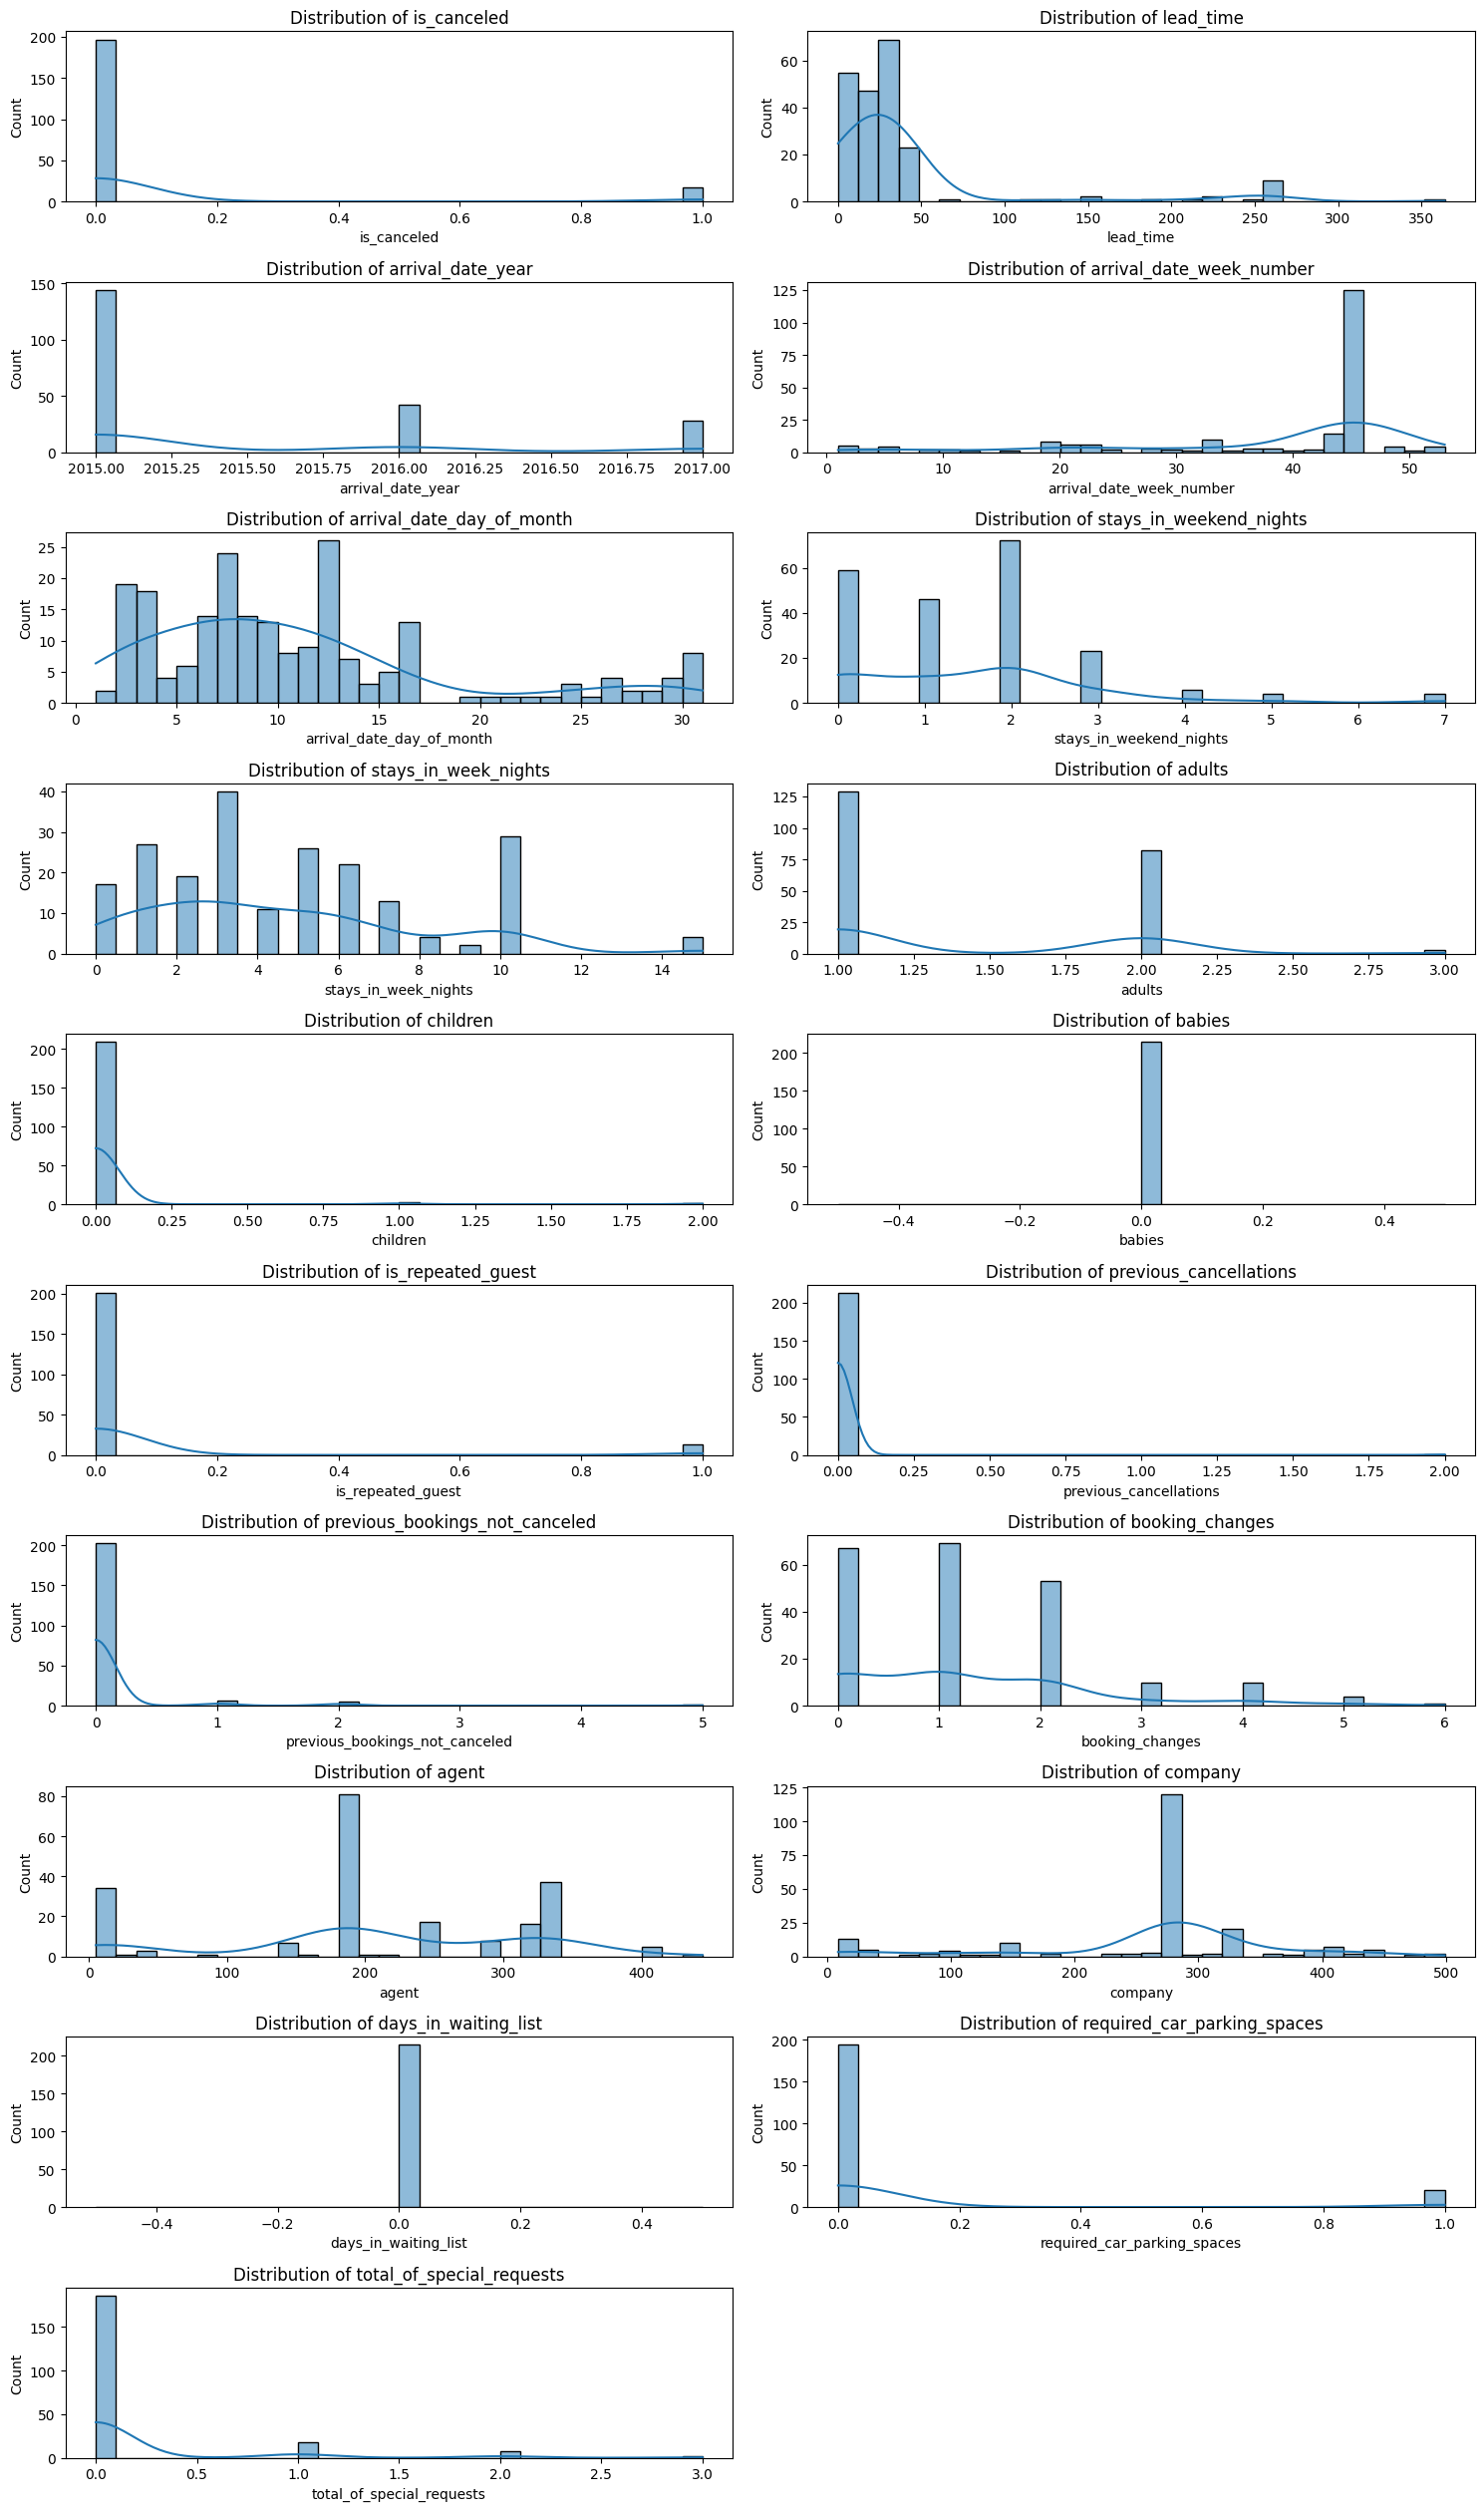

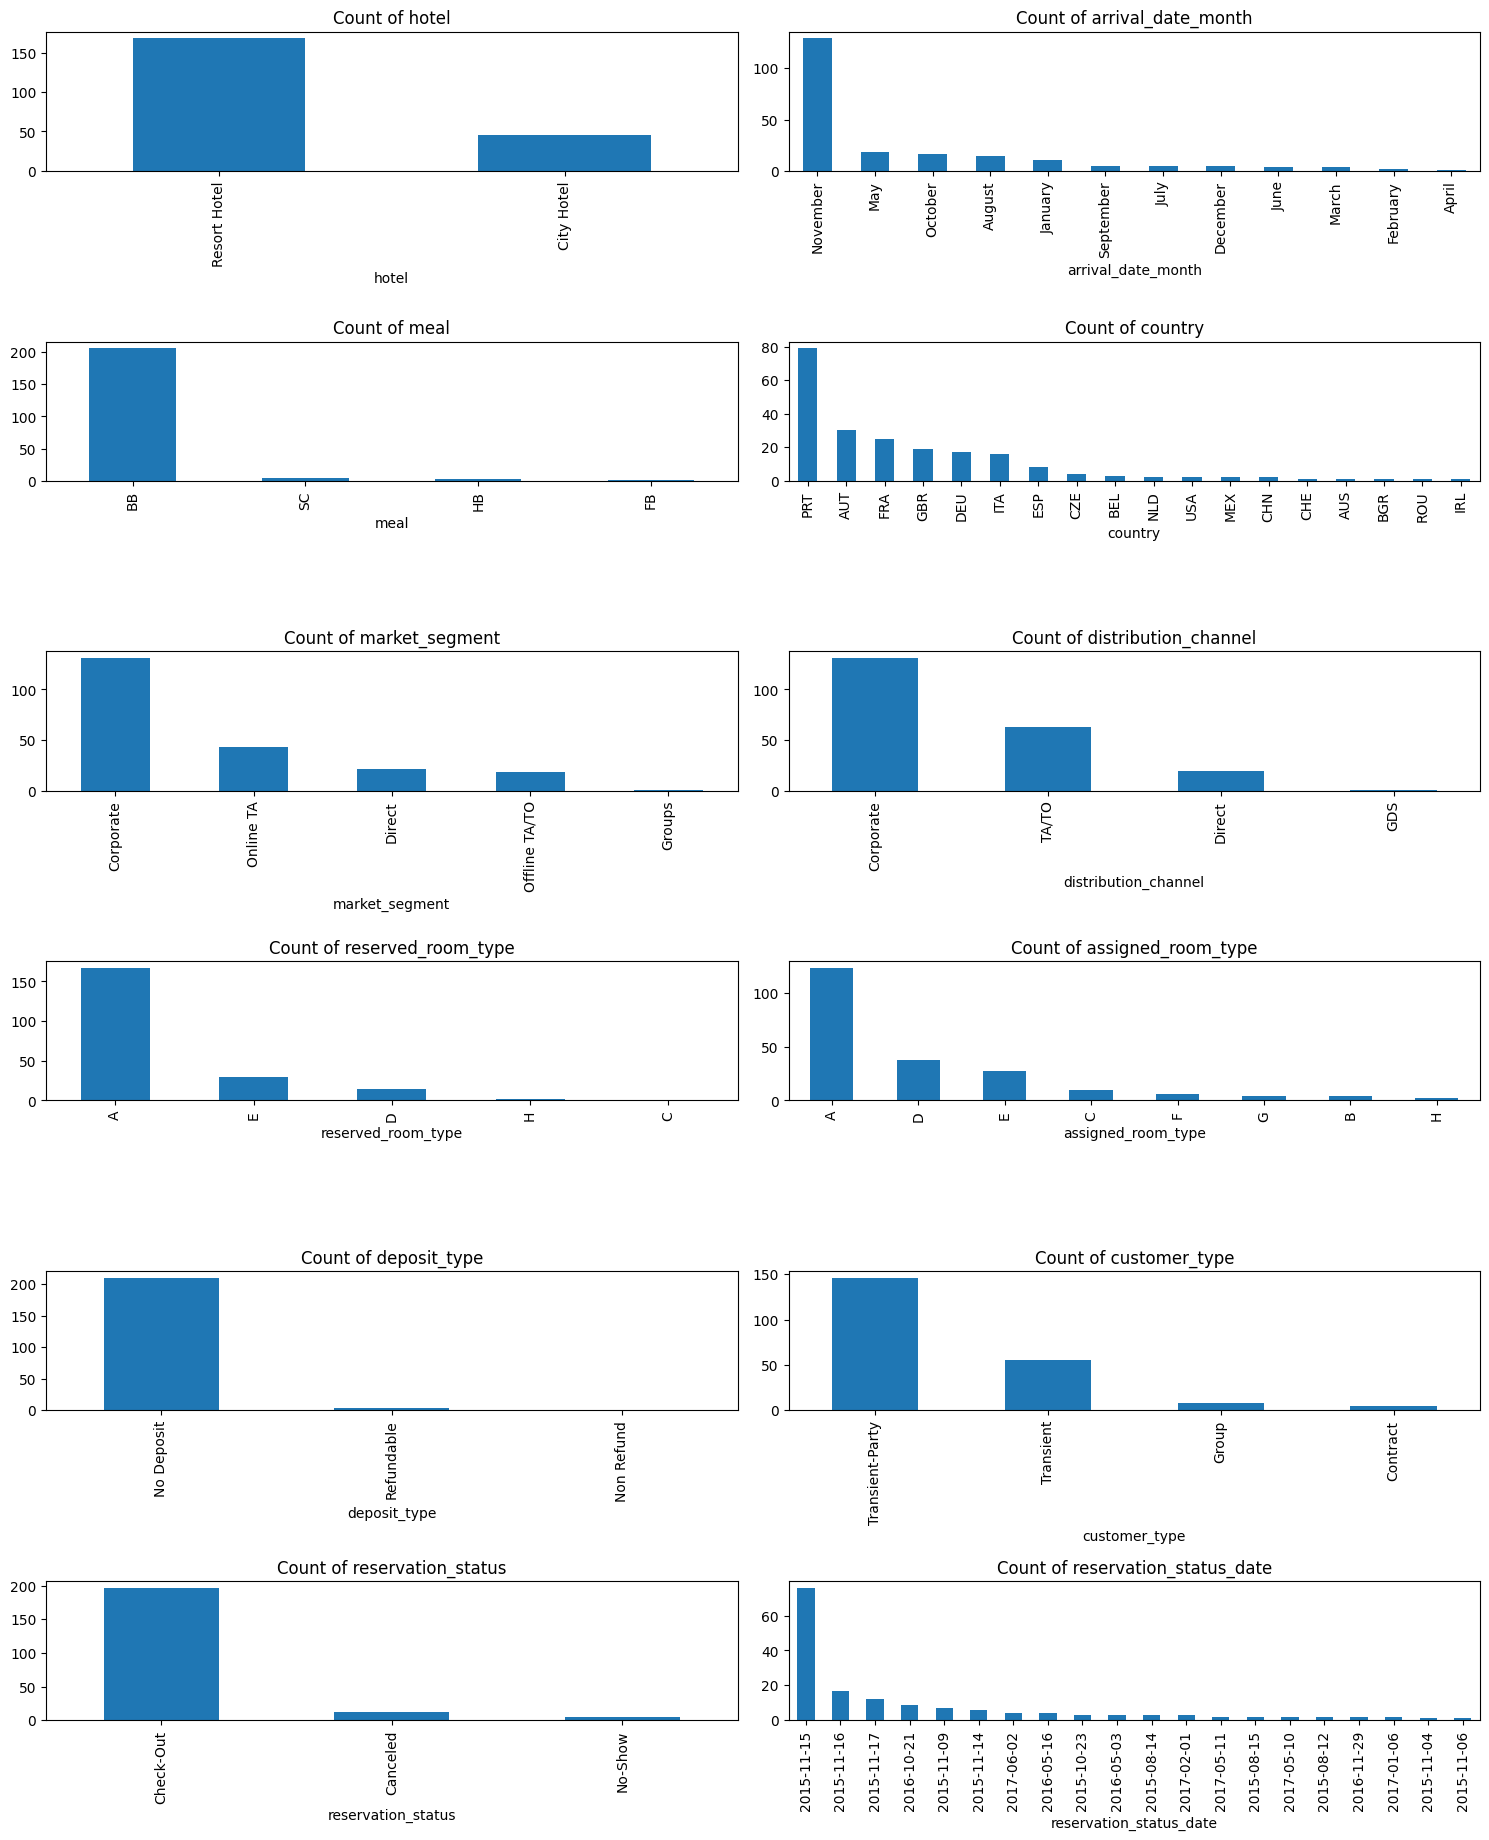

In [43]:
# Univariate Analysis: Numeric columns
import seaborn as sns

numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

# Drop target columns if they are there
for t in ['adr', 'high_adr']:
    if t in numeric_cols:
        numeric_cols.remove(t)

plt.figure(figsize=(15, len(numeric_cols) * 2.5))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Univariate Analysis: Categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
plt.figure(figsize=(15, len(categorical_cols) * 3))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 2, i)
    df[col].value_counts().head(20).plot(kind='bar')
    plt.title(f'Count of {col}')
plt.tight_layout()
plt.show()


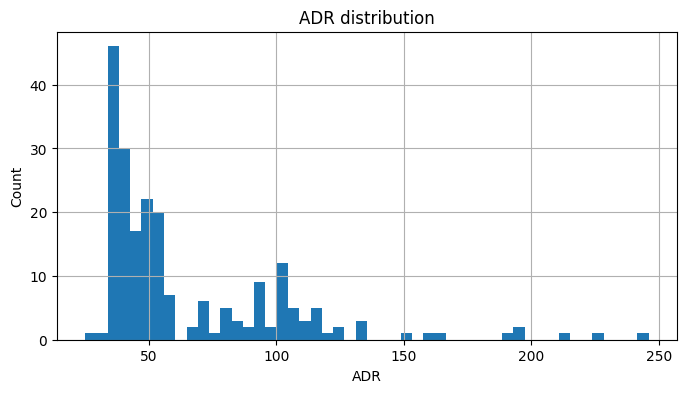

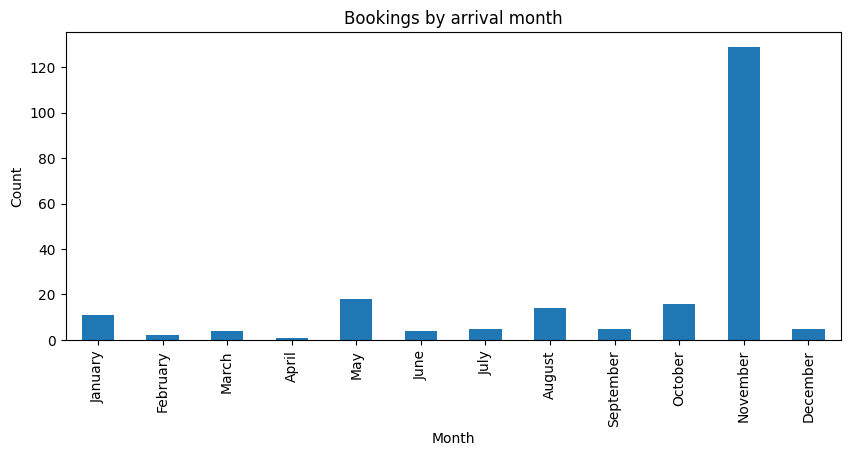

In [44]:
# Cell 5: Visual EDA - ADR distribution and bookings by month
plt.figure(figsize=(8,4))
df['adr'].hist(bins=50)
plt.title('ADR distribution')
plt.xlabel('ADR')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10,4))
if 'arrival_date_month' in df.columns:
    # Keep month order if possible
    try:
        months_order = ["January","February","March","April","May","June","July","August","September","October","November","December"]
        df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'], categories=months_order, ordered=True)
    except:
        pass
    df['arrival_date_month'].value_counts().sort_index().plot(kind='bar')
    plt.title('Bookings by arrival month')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.show()
else:
    print('Column arrival_date_month not present.')


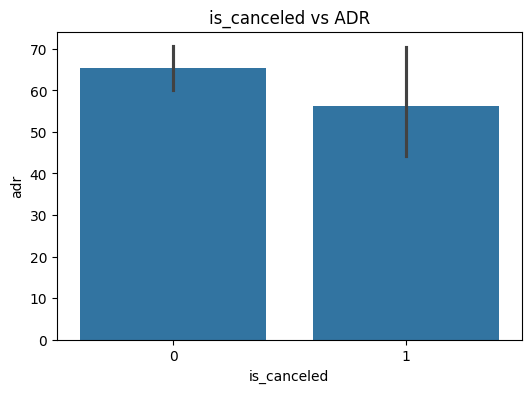

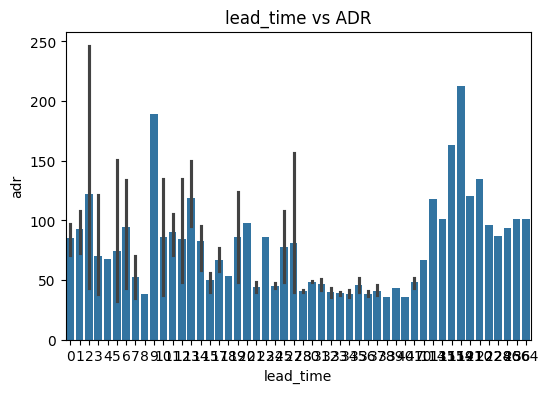

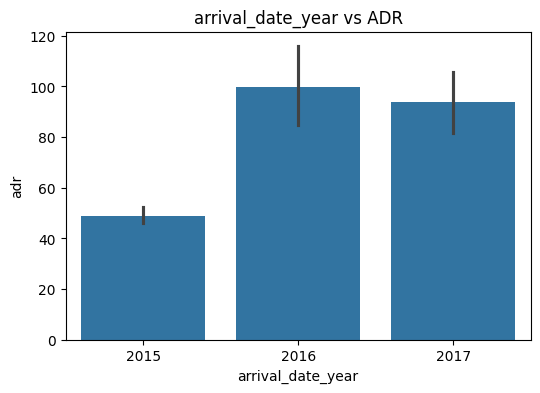

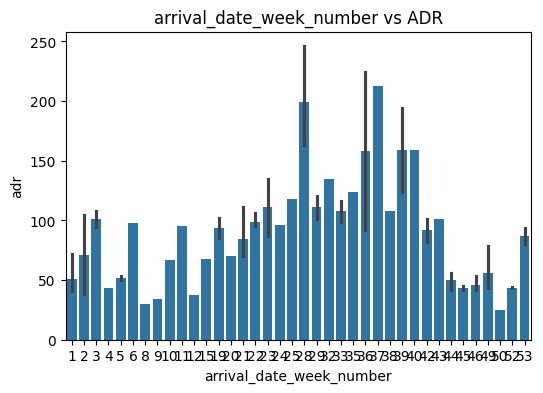

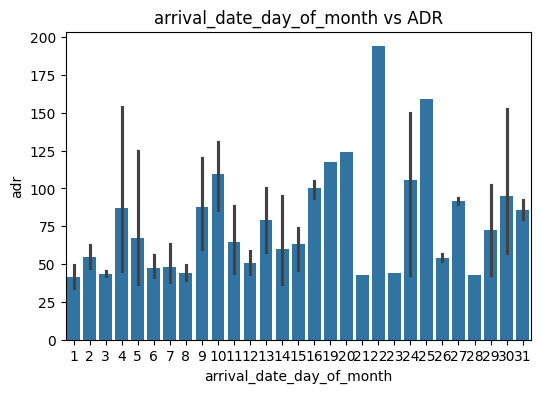

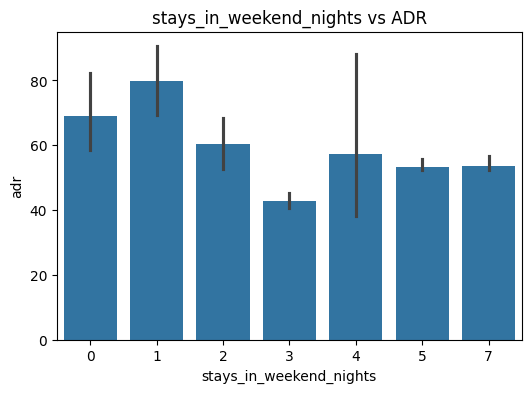

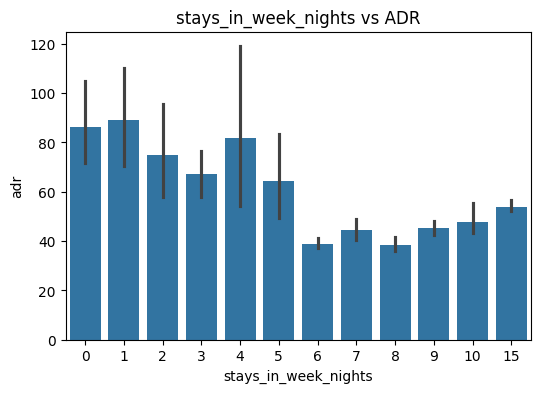

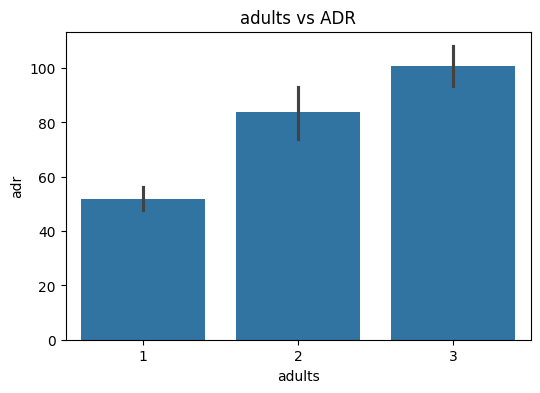

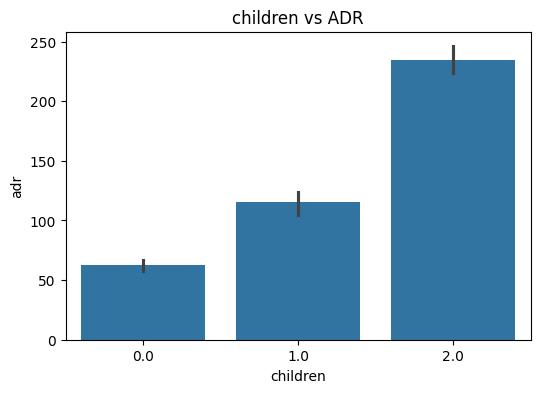

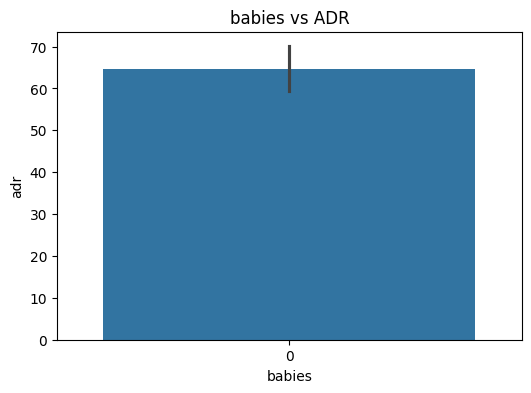

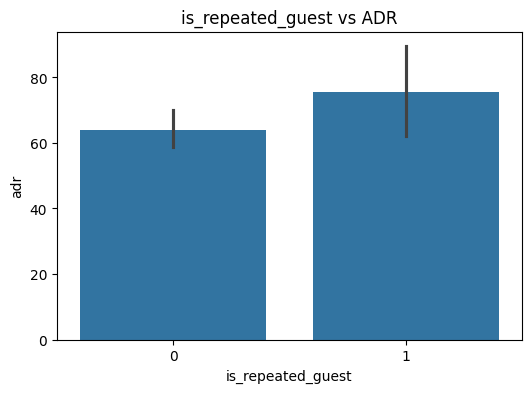

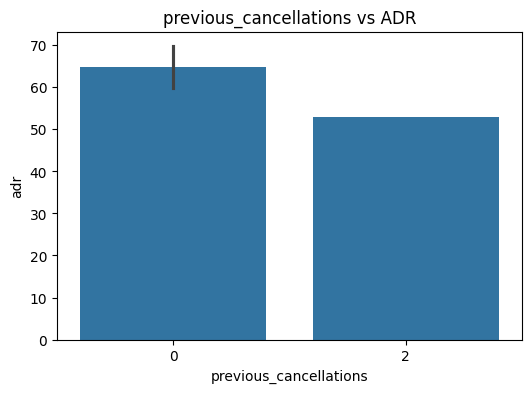

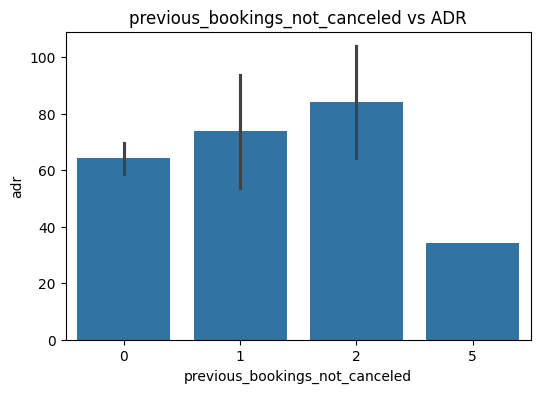

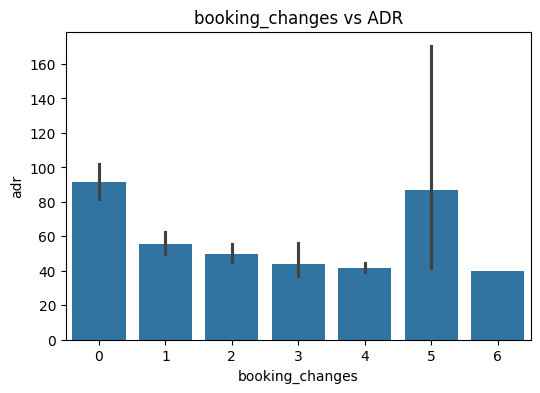

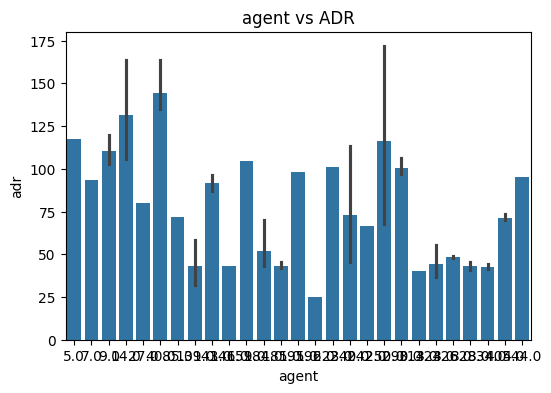

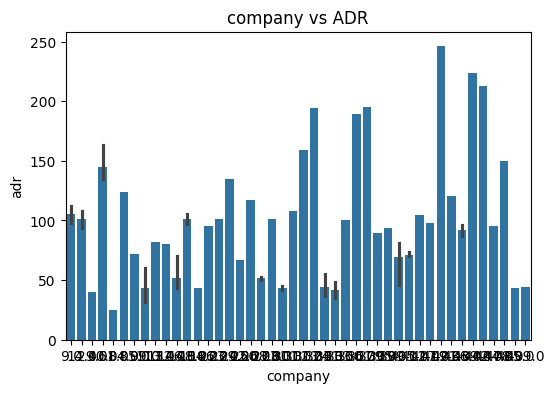

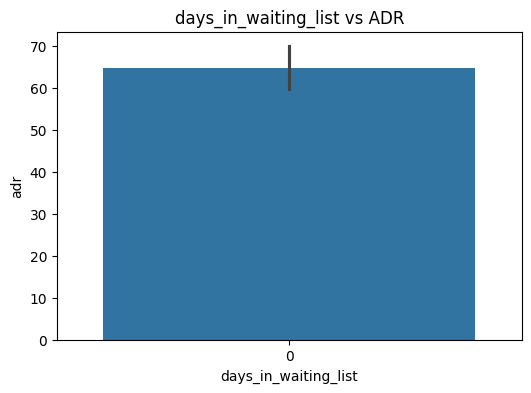

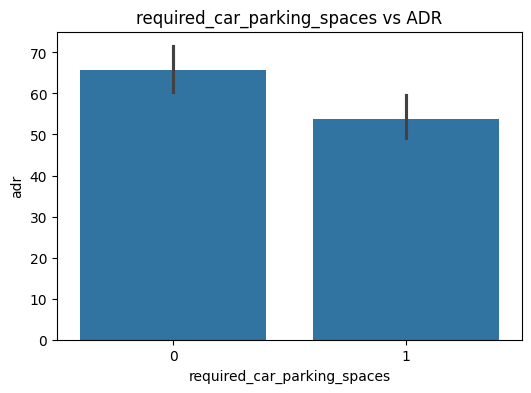

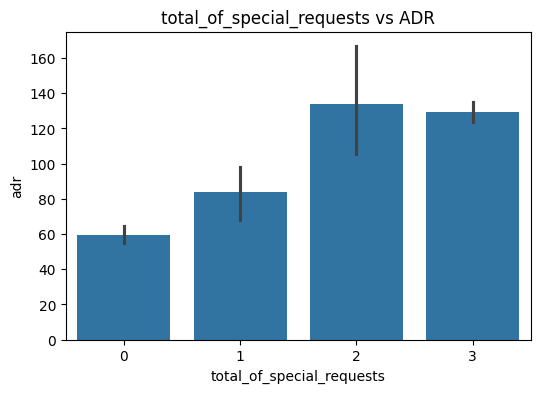

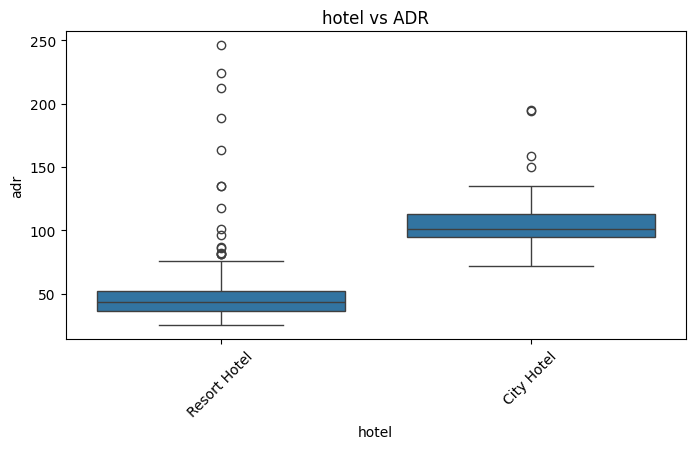

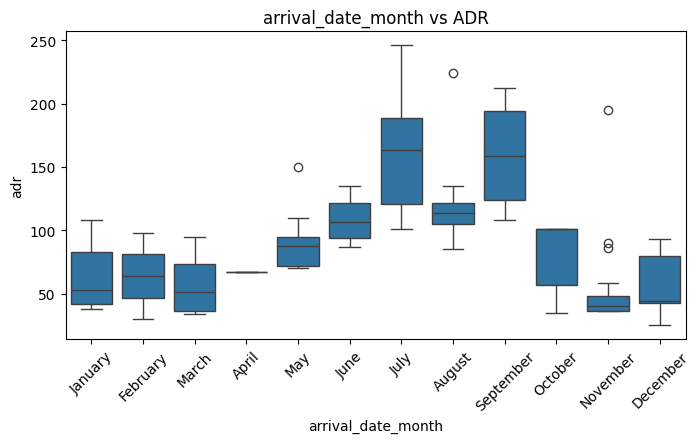

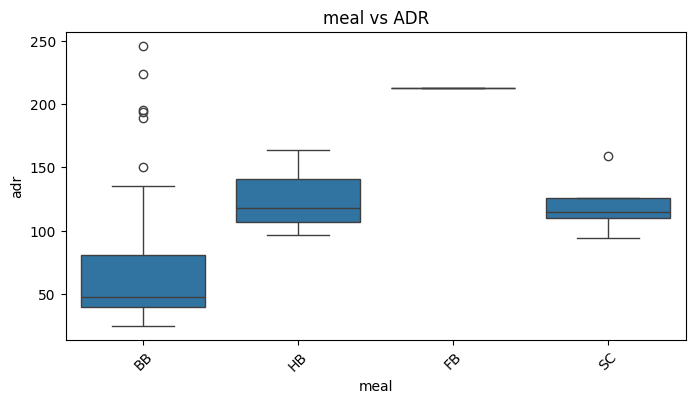

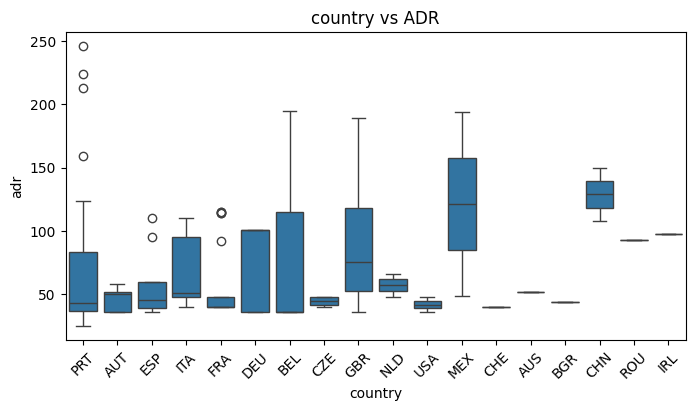

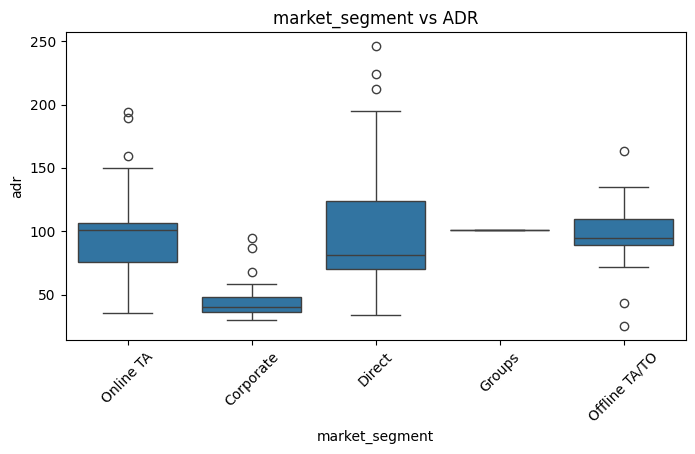

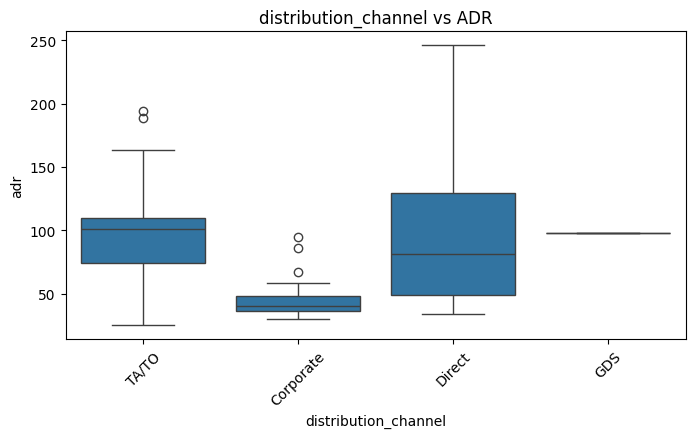

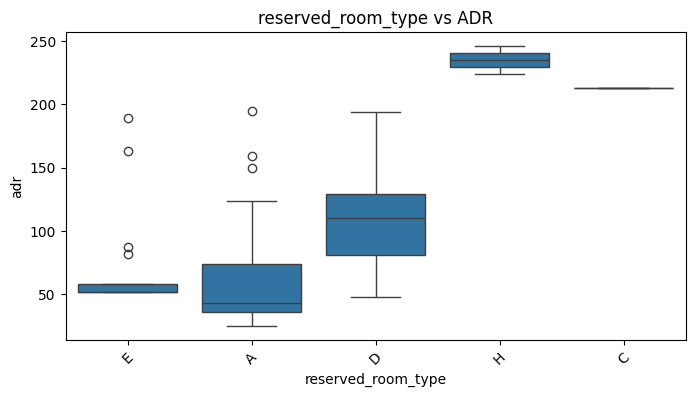

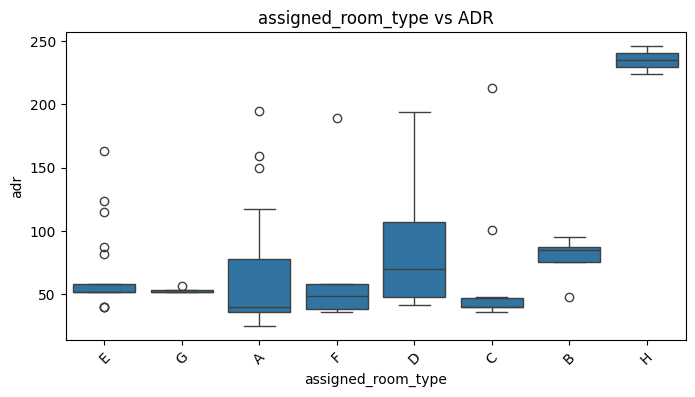

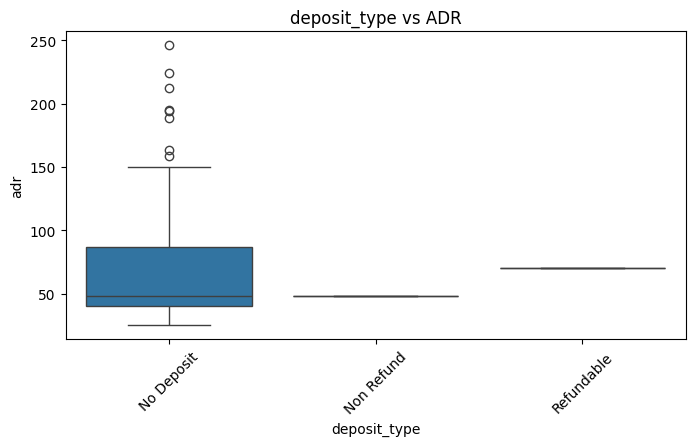

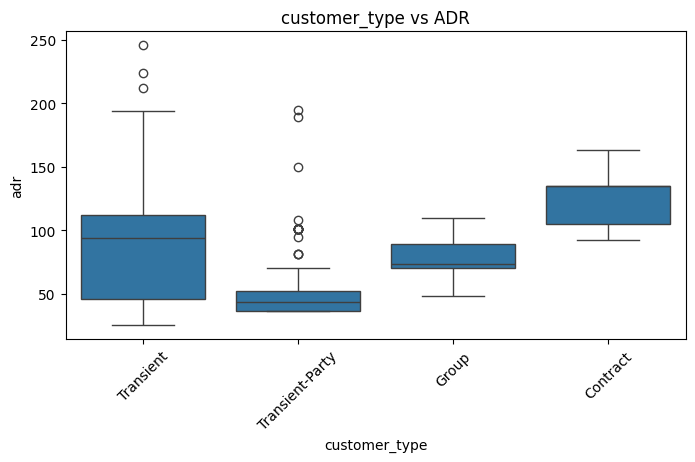

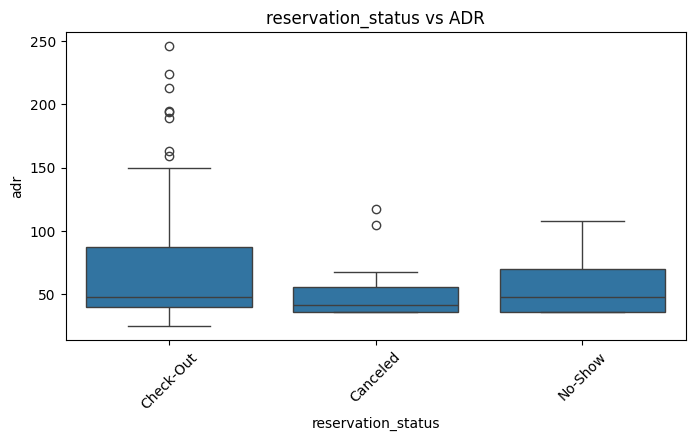

In [45]:
# Bivariate Analysis: Numeric vs Target (adr)
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=df[col], y=df['adr'])
    plt.title(f'{col} vs ADR')
    plt.show()

# Bivariate Analysis: Categorical vs Target (adr)
for col in categorical_cols:
    if df[col].nunique() <= 20:  # Only for low-cardinality categories
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col], y=df['adr'])
        plt.title(f'{col} vs ADR')
        plt.xticks(rotation=45)
        plt.show()


### Preprocessing plan

- Fill missing numeric values with median.
- Fill missing categorical with 'Missing'.
- Encode categoricals with OneHotEncoder (or target/ordinal when applicable).
- Scale numeric features for models that need it.

We'll build a reusable preprocessing pipeline.


In [46]:
#Define preprocessing pipeline
# Identify numeric and categorical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# Remove target columns from features lists if present
for t in ['adr','high_adr','is_canceled']:
    if t in num_cols:
        num_cols.remove(t)

print('Numeric cols sample:', num_cols[:15])
print('Categorical cols sample:', cat_cols[:15])

# Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

print('Preprocessor defined.')


Numeric cols sample: ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company']
Categorical cols sample: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date']
Preprocessor defined.


In [47]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['lead_time', 'arrival_date_year',
                                  'arrival_date_week_number',
                                  'arrival_date_day_of_month',
                                  'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous...
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['hotel', 'arrival_date_month', 'meal',
                                  'country', 'market_segment',
                                  'distribution_channel', 'reserved_room_type',
                                  'assigned_room_type', 'deposit_type',
                                  'customer_type', 'reservation_status',
                                  'reservation_status_date'])])

In [48]:
# Cell 7: Multicollinearity check (VIF) for numeric features
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Only numeric columns (non-target)
X_num = df[num_cols].copy().fillna(df[num_cols].median())

vif_data = pd.DataFrame()
vif_data['feature'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
vif_data.sort_values('VIF', ascending=False).head(15)


,feature,VIF
1,arrival_date_year,37.454001
2,arrival_date_week_number,17.005520
5,stays_in_week_nights,14.992433
14,company,12.721337
6,adults,10.962382
4,stays_in_weekend_nights,9.097293
13,agent,9.001786
3,arrival_date_day_of_month,4.402731
12,booking_changes,3.068902
9,is_repeated_guest,3.008855


If you find features with VIF > 10, consider:

- Dropping one of the correlated features.
- Combining features (e.g., ratio features).
- Using regularized models (Ridge/Lasso) which are more robust to multicollinearity.


In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Select only numeric features (no target)
X = df.select_dtypes(include=['int64','float64']).drop(['adr'], axis=1, errors='ignore')

# Scale features for VIF computation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print("Initial VIF:")
print(vif_data.sort_values(by='VIF', ascending=False))


Initial VIF:
                           Feature       VIF
2                arrival_date_year  5.978791
6             stays_in_week_nights  5.320899
3         arrival_date_week_number  4.592599
5          stays_in_weekend_nights  4.156094
19                        high_adr  3.044327
10               is_repeated_guest  2.841253
12  previous_bookings_not_canceled  2.812249
14                           agent  2.272688
1                        lead_time  2.259954
15                         company  1.822220
4        arrival_date_day_of_month  1.655142
18       total_of_special_requests  1.654847
13                 booking_changes  1.600892
11          previous_cancellations  1.368450
7                           adults  1.357638
8                         children  1.275551
17     required_car_parking_spaces  1.085446
0                      is_canceled  1.071790
9                           babies       NaN
16            days_in_waiting_list       NaN


In [50]:
# Define threshold
vif_threshold = 10

# Iteratively remove features with VIF > threshold
features_to_drop = []

while True:
    X_scaled = scaler.fit_transform(X)
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    
    max_vif = vif_data['VIF'].max()
    if max_vif > vif_threshold:
        drop_feature = vif_data.sort_values(by='VIF', ascending=False)['Feature'].iloc[0]
        print(f"Dropping feature '{drop_feature}' with VIF={max_vif:.2f}")
        X = X.drop(columns=[drop_feature])
        features_to_drop.append(drop_feature)
    else:
        break

print("\nFinal Features after VIF filtering:")
print(X.columns.tolist())
print("\nDropped features due to high VIF:")
print(features_to_drop)



Final Features after VIF filtering:
['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'high_adr']

Dropped features due to high VIF:
[]


In [51]:
# Feature engineering examples
# Example: total_nights, total_guests, is_family
if {'stays_in_weekend_nights','stays_in_week_nights'}.issubset(df.columns):
    df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

if {'adults','children','babies'}.issubset(df.columns):
    df['total_guests'] = df[['adults','children','babies']].sum(axis=1)
else:
    df['total_guests'] = df.get('adults', 0)

df['is_family'] = ((df.get('children',0) + df.get('babies',0)) > 0).astype(int)

display(df[['total_nights','total_guests','is_family']].head())


,total_nights,total_guests,is_family
0,2,2.0,0
1,22,1.0,0
2,3,2.0,0
3,12,1.0,0
4,13,2.0,0


In [52]:
# Prepare data for regression (predicting 'adr')
features = ['lead_time','arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month',
            'stays_in_weekend_nights','stays_in_week_nights','adults','children','babies','meal','country',
            'market_segment','distribution_channel','is_repeated_guest','previous_cancellations','previous_bookings_not_canceled',
            'reserved_room_type','assigned_room_type','booking_changes','deposit_type','agent','company','customer_type',
            'total_nights','total_guests','is_family']

# Keep only existing features (remove adr if present)
features = [f for f in features if f in df.columns]

X = df[features].copy()
y = df['adr'].copy()

# Simple train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (171, 27) Test shape: (43, 27)


In [55]:
# Example: If you originally defined
numeric_features = ['lead_time', 'arrival_date_week_number', 'days_in_waiting_list']
# But days_in_waiting_list is gone:
numeric_features = [col for col in numeric_features if col in X_train.columns]


In [56]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()


In [57]:
if 'days_in_waiting_list' not in df.columns:
    df['days_in_waiting_list'] = 0


In [60]:
# Cell 10: Baseline linear regression pipeline
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model_lr.fit(X_train, y_train)
preds = model_lr.predict(X_test)
print('Baseline LinearRegression RMSE:', root_mean_squared_error(y_test, preds, squared=False))
print('R2:', r2_score(y_test, preds))


ValueError: A given column is not a column of the dataframe